# User -> outlet graph

In [40]:
import numpy as np
import networkx as nx
import pandas as pd
import torch

from tqdm import tqdm
from collections import defaultdict, Counter
from scipy import stats
from itertools import combinations, islice
from sklearn import preprocessing

from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
def mirror_d1d2_iter(df):
    for r1 in df.to_dict('records'):
        yield r1
        r2 = r1.copy()
        r2['d1'], r2['d2'] = r2['d2'], r2['d1']
        yield r2

In [4]:
def mirror_d1d2(df):
    return pd.DataFrame(list(mirror_d1d2_iter(df)))

In [5]:
counts_iter = islice(read_json_gz_lines('../../data/actor-domain-counts.json/'), None)

ACTOR_DOMAIN_COUNTS = {
    (row['actor_id'], row['domain']): row['count']
    for row in tqdm(counts_iter)
}

18010097it [00:55, 324834.58it/s]


In [6]:
ACTORS = list(set([aid for aid, _ in ACTOR_DOMAIN_COUNTS.keys()]))

In [7]:
len(ACTORS)

8132715

In [8]:
DOMAINS = list(set([d for _, d in ACTOR_DOMAIN_COUNTS.keys()]))

In [9]:
PAIRS = [sorted([d1, d2]) for d1, d2 in combinations(DOMAINS, 2)]

In [10]:
ACTOR_TOTAL_LINKS = {}

for aid in tqdm(ACTORS):
    total = sum([ACTOR_DOMAIN_COUNTS.get((aid, d), 0) for d in DOMAINS])
    ACTOR_TOTAL_LINKS[aid] = total

100%|██████████| 8132715/8132715 [01:09<00:00, 117673.28it/s]


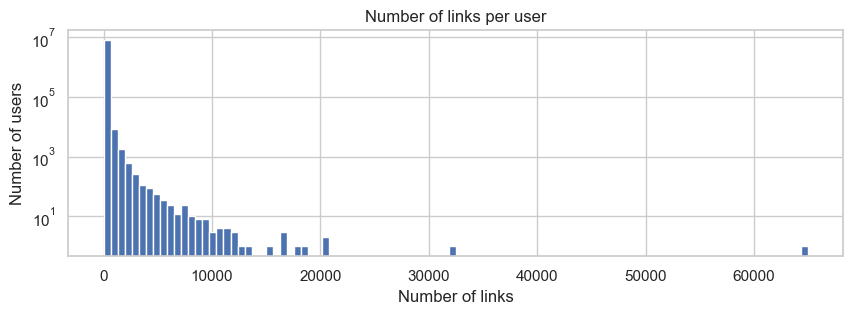

In [11]:
plt.figure(figsize=(10,3), dpi=100)
plt.yscale('log')
_ = plt.hist(list(ACTOR_TOTAL_LINKS.values()), bins=100)
plt.title('Number of links per user')
plt.xlabel('Number of links')
plt.ylabel('Number of users')
plt.savefig('figures/links-per-user.png', bbox_inches='tight')

In [12]:
len([aid for aid, c in ACTOR_TOTAL_LINKS.items() if 10 < c < 100])

687262

In [13]:
len([aid for aid, c in ACTOR_TOTAL_LINKS.items() if c > 10000])

23

In [14]:
len([aid for aid, c in ACTOR_TOTAL_LINKS.items() if c==1])

4321309

In [15]:
4321309 / 8132715

0.5313488791873316

In [16]:
def build_corr_df(min_actor_links=None, max_actor_links=None):
    
    domain_actor_counts = defaultdict(list)

    # Build domain -> (actor1 count, actor2 count...)
    for aid in tqdm(ACTORS):

        # Skip low-vol users.
        if min_actor_links and ACTOR_TOTAL_LINKS[aid] < min_actor_links:
            continue
            
        # Skip high-vol users.
        if max_actor_links and ACTOR_TOTAL_LINKS[aid] > max_actor_links:
            continue

        for d in DOMAINS:
            domain_actor_counts[d].append(ACTOR_DOMAIN_COUNTS.get((aid, d), 0))
            
    # Actor count correlations for each pair.
    rows = []
    for d1, d2 in tqdm(PAIRS):

        c1, c2 = domain_actor_counts[d1], domain_actor_counts[d2]

        sp_corr, _ = stats.spearmanr(c1, c2)
        pr_corr, _ = stats.pearsonr(c1, c2)
        kt_corr, _ = stats.kendalltau(c1, c2)

        rows.append((d1, d2, sp_corr, pr_corr, kt_corr))
        
    df = pd.DataFrame(rows, columns=('d1', 'd2', 'sp_corr', 'pr_corr', 'kt_corr'))
    
    return df

In [30]:
def plot_df(df, dst):
    
    pdf = df.copy()
    pdf['label'] = pdf[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', 1)
    pdf = pd.melt(pdf, ['label'], ['kt_corr', 'sp_corr', 'pr_corr'])
    
    order = list(pdf[pdf.variable=='kt_corr'].sort_values('value', ascending=False).label)
    
    plt.figure(figsize=(3,8), dpi=100)
    sns.barplot(x='value', y='label', data=pdf, hue='variable', order=order[:10]+['....']+order[-10:])
    plt.savefig(dst, bbox_inches='tight')
    plt.show()

In [18]:
df = build_corr_df()

100%|██████████| 105/105 [09:12<00:00,  5.27s/it]


In [19]:
for c1, c2 in combinations(['sp_corr', 'kt_corr', 'pr_corr'], 2):
    print(c1, c2, stats.kendalltau(df[c1], df[c2]))

sp_corr kt_corr KendalltauResult(correlation=0.972161172161172, pvalue=6.711309935834727e-49)
sp_corr pr_corr KendalltauResult(correlation=0.5706959706959707, pvalue=6.250984465683815e-18)
kt_corr pr_corr KendalltauResult(correlation=0.5516483516483516, pvalue=7.43554663585714e-17)


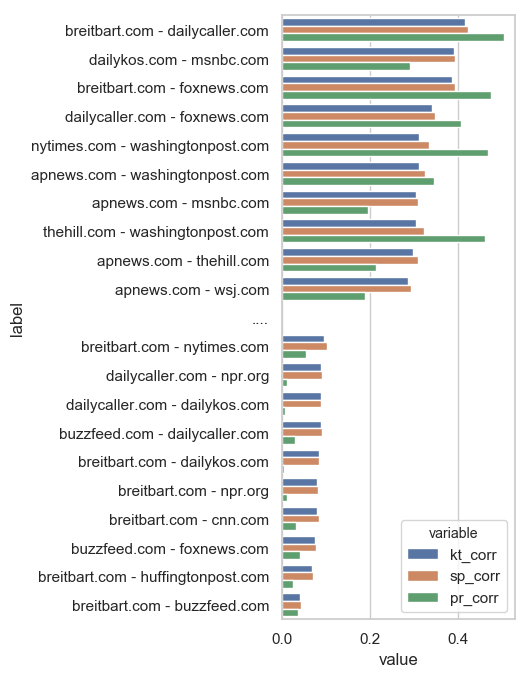

In [31]:
plot_df(df, 'figures/user-graph-bars-all.png')

In [21]:
df_10_100 = build_corr_df(10, 100)

100%|██████████| 105/105 [00:53<00:00,  2.06it/s]


In [22]:
for c1, c2 in combinations(['sp_corr', 'kt_corr', 'pr_corr'], 2):
    print(c1, c2, stats.kendalltau(df_10_100[c1], df_10_100[c2]))

sp_corr kt_corr KendalltauResult(correlation=0.9633699633699633, pvalue=4.7338735332829104e-48)
sp_corr pr_corr KendalltauResult(correlation=0.8787545787545787, pvalue=2.8235163276830376e-40)
kt_corr pr_corr KendalltauResult(correlation=0.8589743589743588, pvalue=1.4672625664600186e-38)


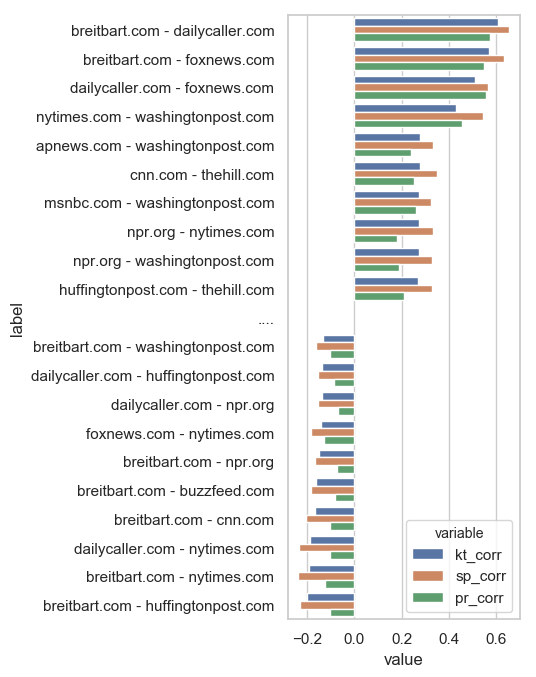

In [32]:
plot_df(df_10_100, 'figures/user-graph-bars-10-100.png')

In [34]:
ug = df.merge(df_10_100, on=['d1', 'd2'], suffixes=['_0', '_10_100'])

In [35]:
ug = mirror_d1d2(ug)

In [36]:
for col in set(ug.columns) - {'d1', 'd2'}:
    ug[col] = preprocessing.scale(ug[col])

In [37]:
ug.head(10)

,d1,d2,kt_corr_0,kt_corr_10_100,pr_corr_0,pr_corr_10_100,sp_corr_0,sp_corr_10_100
0,breitbart.com,thehill.com,-0.274260,-0.597331,-0.349523,-0.512483,-0.263029,-0.605274
1,thehill.com,breitbart.com,-0.274260,-0.597331,-0.349523,-0.512483,-0.263029,-0.605274
2,breitbart.com,nytimes.com,-1.386702,-1.817993,-0.714996,-1.362410,-1.370617,-1.901363
3,nytimes.com,breitbart.com,-1.386702,-1.817993,-0.714996,-1.362410,-1.370617,-1.901363
4,bloomberg.com,breitbart.com,-1.043963,-0.884885,-0.993899,-0.738424,-1.077555,-0.878391
5,breitbart.com,bloomberg.com,-1.043963,-0.884885,-0.993899,-0.738424,-1.077555,-0.878391
6,breitbart.com,foxnews.com,2.505287,2.920984,2.686022,3.477444,2.457397,2.756512
7,foxnews.com,breitbart.com,2.505287,2.920984,2.686022,3.477444,2.457397,2.756512
8,breitbart.com,buzzfeed.com,-2.115378,-1.631929,-0.869927,-1.056541,-2.148358,-1.598365
9,buzzfeed.com,breitbart.com,-2.115378,-1.631929,-0.869927,-1.056541,-2.148358,-1.598365


In [38]:
ug.to_json('data/user-graph.json', orient='records', lines=True)

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


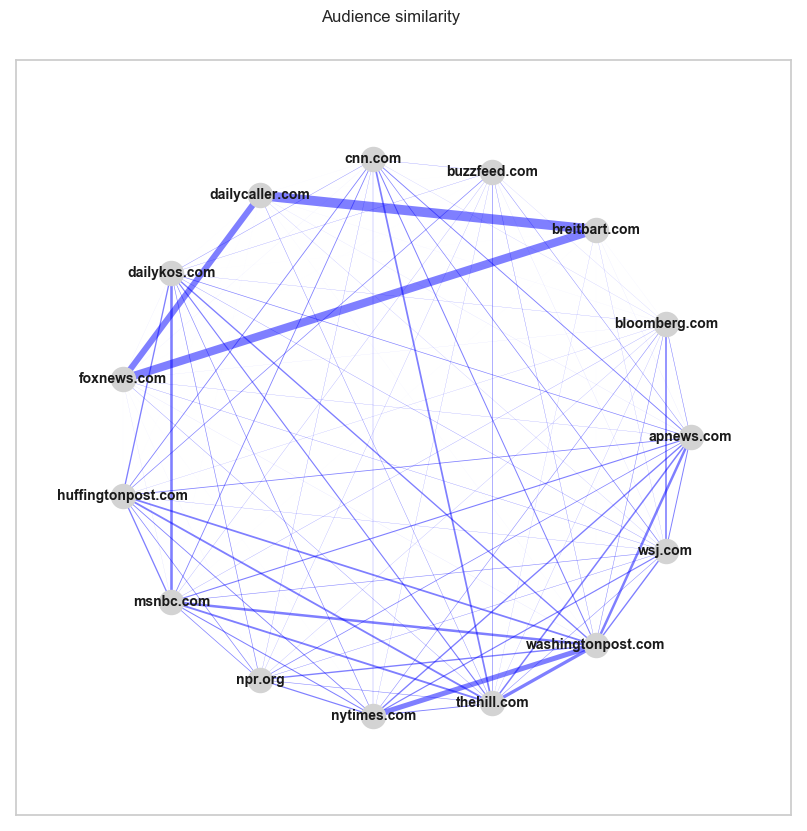

In [46]:
metrics = set(ug.columns) - {'d1', 'd2'}

graph_df = ug.copy()
graph_df['mean_score'] = graph_df.apply(lambda r: np.mean([r[m] for m in metrics]), 1)
graph_df['pair'] = graph_df.apply(lambda r: tuple(sorted([r.d1, r.d2])), 1)
graph_df = graph_df.groupby('pair').mean()
graph_df['width'] = (preprocessing.minmax_scale(graph_df.mean_score, (0,1))**3)*7

g = nx.Graph()
for r in graph_df.itertuples():
    g.add_edge(r.Index[0], r.Index[1], width=r.width)
    
edge_width = [d['width'] for _, _, d in g.edges(data=True)]

plt.figure(figsize=(10,10), dpi=100)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.suptitle('Audience similarity', y=0.93)

pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='lightgray')
nx.draw_networkx_edges(g, pos, width=edge_width, alpha=0.5, edge_color='blue')
_ = nx.draw_networkx_labels(g, pos, font_weight='bold', font_size=10)
plt.savefig('figures/user-graph-radial-all-metrics.png', bbox_inches='tight')